In [96]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torch.utils.data import Dataset
import csv
from PIL import Image
import re

cudnn.benchmark = True
plt.ion()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dataset

In [97]:
class CustomDataset(Dataset):
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.main_dir = os.path.join(path)
        self.all_imgs = sorted(os.listdir(self.main_dir), key=lambda s: int(re.search(r'\d+', s).group()))
        
    def __len__(self):
        return len(self.all_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

Device

In [98]:
#apple
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
#windows
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


Load Data

In [99]:

data_transforms =  transforms.Compose([
        transforms.Resize((512,512)),
        transforms.ToTensor(),
    ])
directory = os.getcwd()
data_dir = '/Users/nayansavaliya/Desktop/AnomalyDetection/data/transistor/train/good'
train_dataset = CustomDataset(data_dir,data_transforms)
train_dataloader =  torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                             shuffle=False, num_workers=0)

View Data

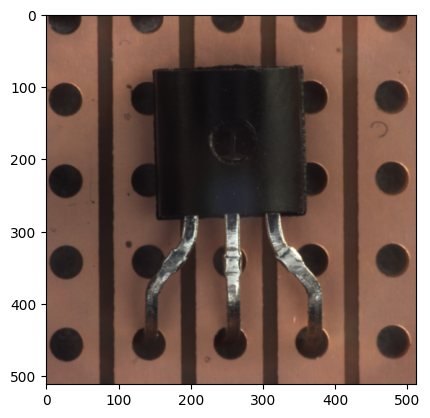

In [100]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of  data
inputs = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

Datasets & DataLoaders

In [101]:
image_datasets = {'train': train_dataset }
dataloaders = {'train': train_dataloader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}


Encoder

In [102]:
class Encoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(1048576, 128),
            nn.ReLU(),
            nn.Linear(128, 32)
        )
        
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        print(x.shape)
        x = self.linear(x)
        return x
    
    
class Decoder(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(True),
            nn.Linear(128, 64*128*128),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(64, 128, 128))

        self.invconv = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
           # nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
           # nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(3),
            nn.ReLU(True),
        )
        
    def forward(self, x):
        x = self.linear(x)
        x = self.unflatten(x)
        
        x = self.invconv(x)
        x = torch.sigmoid(x)
        return x

torch.Size([1, 1048576])
torch.Size([1, 32])


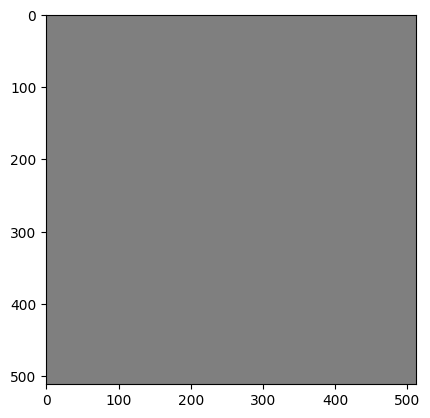

In [103]:
model = Encoder()
inputs = next(iter(train_dataloader))
out = model(inputs)
print(out.shape)
model = Decoder()
out = model(out)
out = torchvision.utils.make_grid(out)
out =  out.detach()
imshow(out)